In [2]:
# @title Drive
from google.colab import drive
drive.mount('/content/drive')

data_drive_path = "/content/drive/MyDrive/MastersProject/Data/"
plot_drive_path = "/content/drive/MyDrive/MastersProject/Plots/"



Mounted at /content/drive


In [3]:
# @title Import Libraries
import xarray as xr
import numpy as np
import pandas as pd
import joblib

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Aesthetics
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=12, labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
# @title Loading Data
merged_datasets = joblib.load(data_drive_path+ "aiwp_ml_setup_500geopotential_32x64_2020_leadtime72.pkl").drop(columns=["area_weight","keisler"])
print(f"Merged_datasets size:{merged_datasets.shape} ")
merged_datasets.head()

Merged_datasets size:(1499136, 7) 


,time,longitude,latitude,graphcast,pangu,neuralgcm,ifshres
0,2020-01-04,0.0,-87.1875,49969.980469,49928.015625,50061.421875,50103.640625
1,2020-01-04,0.0,-81.5625,50197.351562,50232.875000,50227.707031,50357.289062
2,2020-01-04,0.0,-75.9375,50326.664062,50367.367188,50305.351562,50433.640625
3,2020-01-04,0.0,-70.3125,50008.304688,50005.089844,49969.562500,50055.031250
4,2020-01-04,0.0,-64.6875,49281.628906,49232.839844,49214.851562,49303.812500


In [5]:
era5_dataset = joblib.load(data_drive_path+ "era5_ml_setup_500geopotential_32x64_2020.pkl")
print(f"era5_dataset size:{era5_dataset.shape} ")
era5_dataset.head()

era5_dataset size:(1556480, 5) 


,time,longitude,latitude,era5,area_weight
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555


In [6]:
# @title Merge Forecasts and Era5

#merged_datasets = merged_datasets.rename(columns={col: col + "_lt72" for col in merged_datasets.columns if col not in ["time", "longitude", "latitude"]})
df = era5_dataset.merge(merged_datasets, on=["time", "longitude", "latitude"], how="outer")

print(f"Dataframe size: {df.shape}")
df.head()

Dataframe size: (1556480, 9)


,time,longitude,latitude,era5,area_weight,graphcast,pangu,neuralgcm,ifshres
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN


In [7]:
df.isna().sum()


,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
graphcast,57344
pangu,57344
neuralgcm,57344
ifshres,57344


In [9]:
df_not_null = df.dropna()

In [10]:
df_not_null.head()

,time,longitude,latitude,era5,area_weight,graphcast,pangu,neuralgcm,ifshres
12288,2020-01-04,0.0,-87.1875,50122.613281,0.049068,49969.980469,49928.015625,50061.421875,50103.640625
12289,2020-01-04,0.0,-81.5625,50243.335938,0.146730,50197.351562,50232.875000,50227.707031,50357.289062
12290,2020-01-04,0.0,-75.9375,50384.082031,0.242980,50326.664062,50367.367188,50305.351562,50433.640625
12291,2020-01-04,0.0,-70.3125,50042.835938,0.336890,50008.304688,50005.089844,49969.562500,50055.031250
12292,2020-01-04,0.0,-64.6875,49216.960938,0.427555,49281.628906,49232.839844,49214.851562,49303.812500


In [11]:
df_not_null.isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
graphcast,0
pangu,0
neuralgcm,0
ifshres,0


### Calculate RMSE to compare to values on [WB2 website](https://sites.research.google/weatherbench/deterministic-scores/)



In [12]:
def calculate_pairwise_rmse(df, columns):
    """Calculates the pairwise RMSE between specified columns in a DataFrame.

    Args:
      df: The input DataFrame.
      columns: A list of column names to calculate RMSE for.

    Returns:
      A pandas DataFrame representing the pairwise RMSE matrix.
    """

    n = len(columns)
    rmse_matrix = pd.DataFrame(index=columns, columns=columns)

    for i in range(n):
      for j in range(i, n):  # Only calculate upper triangle, as it is symmetric
          col1 = columns[i]
          col2 = columns[j]

          rmse = np.sqrt(((df[col1] - df[col2])**2 * df["area_weight"]).mean() / df["area_weight"].mean())
          rmse_matrix.loc[col1, col2] = rmse
          rmse_matrix.loc[col2, col1] = rmse # Assign to the lower triangle as well

    return rmse_matrix



In [13]:
columns_to_calculate = [ 'era5','graphcast', 'pangu', 'neuralgcm','ifshres']
pairwise_rmse_result = calculate_pairwise_rmse(df_not_null, columns_to_calculate)
pairwise_rmse_result

,era5,graphcast,pangu,neuralgcm,ifshres
era5,0.0,115.160156,125.908476,104.454006,124.894767
graphcast,115.160156,0.0,105.998268,102.279047,113.080117
pangu,125.908476,105.998268,0.0,104.273869,119.072937
neuralgcm,104.454006,102.279047,104.273869,0.0,111.085068
ifshres,124.894767,113.080117,119.072937,111.085068,0.0


In [14]:
#convert datatype object to float
pairwise_rmse_result = pairwise_rmse_result.apply(pd.to_numeric, errors='coerce')
# Create a mask for the upper triangle excluding the main diagonal
mask = np.triu(np.ones_like(pairwise_rmse_result, dtype=bool),k=1)

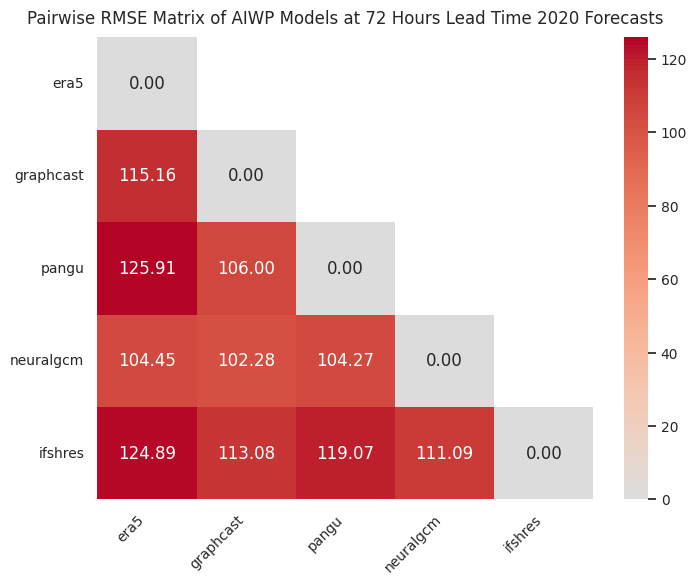

In [15]:
# plot the heatmap

def pairwise_rmse_heatmap(rmse_result, mask, save_path):
  plt.figure(figsize=(8,6))
  sns.heatmap(rmse_result,mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f')
  plt.title('Pairwise RMSE Matrix of AIWP Models at 72 Hours Lead Time 2020 Forecasts', pad=10)
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45° and align right
  plt.yticks(rotation=0)  # Keep y-axis labels horizontal
  plt.grid(False)
  plt.savefig(save_path +'Pairwise RMSE Matrix of AIWP Models at 72 Hours Lead Time 2020 Forecasts.pdf', dpi=300, bbox_inches="tight")
  plt.show()

pairwise_rmse_heatmap(pairwise_rmse_result, mask, plot_drive_path)

Do they equal RMSE of 115? Yes they do! ✅

In [16]:
[pairwise_rmse_result.index]

[Index(['era5', 'graphcast', 'pangu', 'neuralgcm', 'ifshres'], dtype='object')]

In [17]:
pairwise_rmse_result.shape

(5, 5)

In [18]:
pairwise_rmse_result.values

array([[  0.        , 115.16015644, 125.90847575, 104.45400604,
        124.89476667],
       [115.16015644,   0.        , 105.99826804, 102.27904686,
        113.08011652],
       [125.90847575, 105.99826804,   0.        , 104.27386937,
        119.07293684],
       [104.45400604, 102.27904686, 104.27386937,   0.        ,
        111.0850685 ],
       [124.89476667, 113.08011652, 119.07293684, 111.0850685 ,
          0.        ]])

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Convert the filtered DataFrame to a NumPy array
distance_matrix = pairwise_rmse_result.values

# Apply MDS using the precomputed distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=2)
coords = mds.fit_transform(distance_matrix)

In [21]:
coords


array([[-22.10132652,  75.29020009],
       [ 41.43006003, -45.73750012],
       [-34.37532888, -67.49889948],
       [-54.01962666,   6.76824562],
       [ 69.06622203,  31.17795389]])

In [20]:
print(f"MDS stress: {mds.stress_:.2f}")


MDS stress: 5641.70


index = 0 and label = era5
index = 1 and label = graphcast
index = 2 and label = pangu
index = 3 and label = neuralgcm
index = 4 and label = ifshres


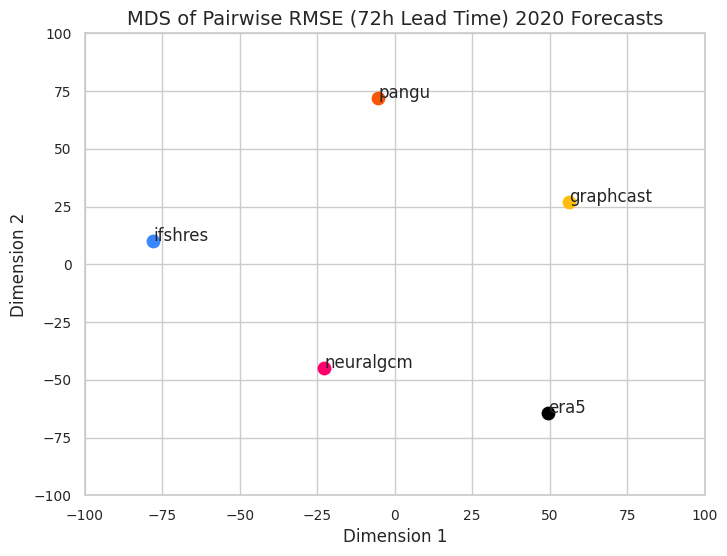

In [38]:
color_dict = {
    "graphcast": "#ffbe0b",
    "pangu": "#fb5607",
    "neuralgcm": "#ff006e",
    "ifshres": "#3a86ff"
}

def plot_mds_coords(labels, color_dict, coords, save_path):
  plt.figure(figsize=(8, 6))
  for i, label in enumerate(labels):
      print(f'index = {i} and label = {label}')
      # Use black for ERA5, otherwise find the first matching key in color_dict
      dataset_color = 'black' if 'era5' in label else next((color for key, color in color_dict.items() if key in label), None)
      if dataset_color is None:
          continue
      plt.scatter(coords[i, 0], coords[i, 1], color=dataset_color, edgecolors=dataset_color, alpha=1, s=80)
      plt.annotate(label, (coords[i, 0], coords[i, 1]))

  plt.title('MDS of Pairwise RMSE (72h Lead Time) 2020 Forecasts')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.xlim([-100, 100])
  plt.ylim([-100, 100])
  plt.grid(True)
  plt.savefig(f'{save_path}MDS of Pairwise RMSE (72h Lead Time) 2020 Forecasts.pdf', dpi=300, bbox_inches="tight")
  plt.show()

plot_mds_coords(pairwise_rmse_result.index, color_dict, coords, plot_drive_path)


In [23]:
# @title Distance to ERA5

distances = np.linalg.norm(coords - coords[0], axis=1)
model_names = ['ERA5', 'GraphCast', 'Pangu', 'NeuralGCM', 'IFSHRES']
for name, dist in zip(model_names, distances):
    print(f"{name:12s}: {dist:.2f}")

ERA5        : 0.00
GraphCast   : 91.57
Pangu       : 146.80
NeuralGCM   : 74.84
IFSHRES     : 147.43


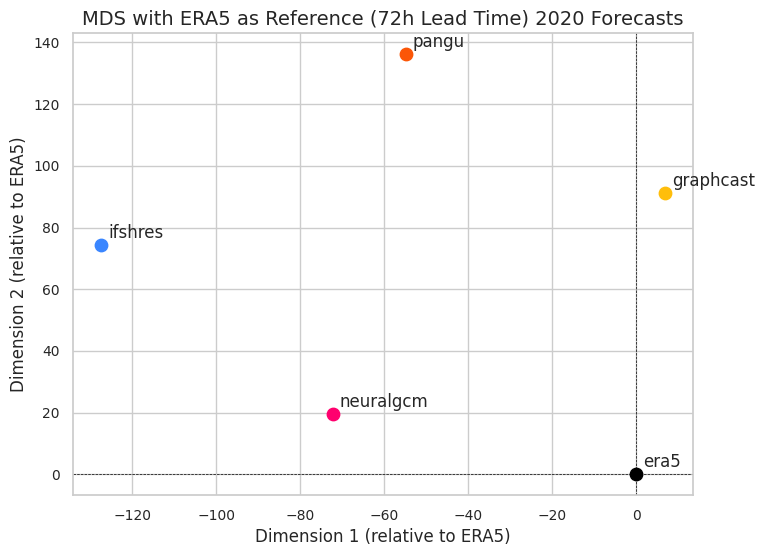

In [36]:
def plot_mds_with_era5_as_reference(coords, labels, color_dict, save_path):
    # Translate coordinates so ERA5 is at the origin
    ref_coord = coords[0]
    translated_coords = coords - ref_coord  # ERA5 becomes (0, 0)


    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    plt.figure(figsize=(8, 6))

    for i, label in enumerate(labels):
        dataset_color = 'black' if 'era5' in label else next((color for key, color in color_dict.items() if key in label), None)
        if dataset_color is None:
            continue
        x, y = translated_coords[i]
        plt.scatter(x, y, color=dataset_color, edgecolors=dataset_color, alpha=1, s=80)
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(5,5), ha='left')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.title('MDS with ERA5 as Reference (72h Lead Time) 2020 Forecasts')
    plt.xlabel('Dimension 1 (relative to ERA5)')
    plt.ylabel('Dimension 2 (relative to ERA5)')
    # plt.xlim([-200, 200])
    # plt.ylim([-200, 200])
    plt.grid(True)
    plt.savefig(save_path + "MDS with ERA5 as Reference (72h Lead Time) 2020 Forecasts.pdf" , dpi=300, bbox_inches="tight")
    plt.show()

plot_mds_with_era5_as_reference(coords, pairwise_rmse_result.index, color_dict,plot_drive_path )


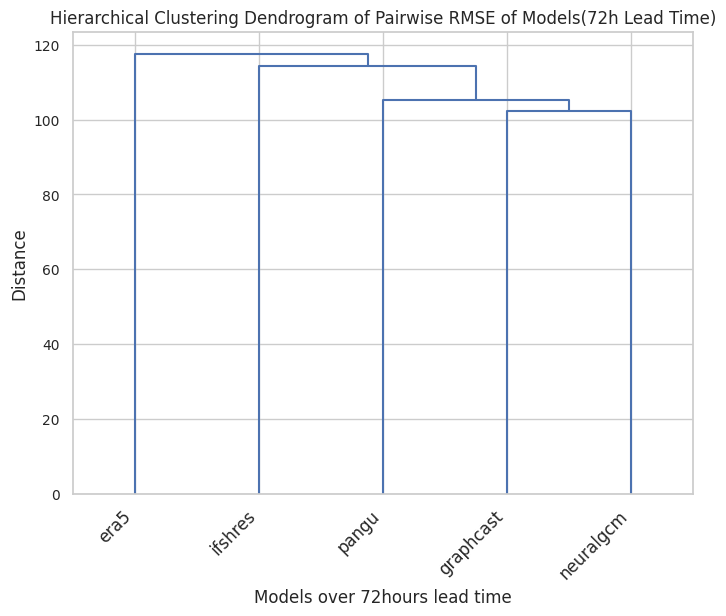

In [25]:
# @title Create the dendrogram plot
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Convert the DataFrame to a NumPy array
distance_matrix = pairwise_rmse_result.values

# If your RMSE matrix is symmetric and represents distances,
# convert it to a condensed distance matrix
condensed_distance = squareform(distance_matrix)

# Compute the linkage matrix using a method of your choice (e.g., 'average')
Z = linkage(condensed_distance, method='average')

# Create the dendrogram plot
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.figure(figsize=(8, 6))

# plt.figure(figsize=(12, 8))
dendrogram(Z, labels=pairwise_rmse_result.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(72h Lead Time)')
plt.xlabel('Models over 72hours lead time')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45° and align right


plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(72h Lead Time).pdf', dpi=300, bbox_inches="tight")

plt.show()


In [26]:
columns_to_calculate_test = ['era5','graphcast', 'pangu', 'neuralgcm','ifshres']
pairwise_rmse_result_test = calculate_pairwise_rmse(df_not_null, columns_to_calculate_test)
pairwise_rmse_result_test

,era5,graphcast,pangu,neuralgcm,ifshres
era5,0.0,115.160156,125.908476,104.454006,124.894767
graphcast,115.160156,0.0,105.998268,102.279047,113.080117
pangu,125.908476,105.998268,0.0,104.273869,119.072937
neuralgcm,104.454006,102.279047,104.273869,0.0,111.085068
ifshres,124.894767,113.080117,119.072937,111.085068,0.0


In [27]:
# @title 3D MDS
mds_test = MDS(n_components=3, dissimilarity='precomputed',metric=True,normalized_stress=False, random_state=42)
coords_test = mds_test.fit_transform(pairwise_rmse_result_test)

In [28]:
coords_test

array([[ 62.48384172, -36.44039688, -30.83243908],
       [  3.59501301, -32.94627228,  54.87939116],
       [ -3.46885447,  60.77868252,  42.34006367],
       [  6.73311372,  36.31150219, -45.35961361],
       [-69.34311398, -27.70351555, -21.02740214]])

In [29]:
print(f"MDS stress: {mds_test.stress_:.2f}")


MDS stress: 1343.74


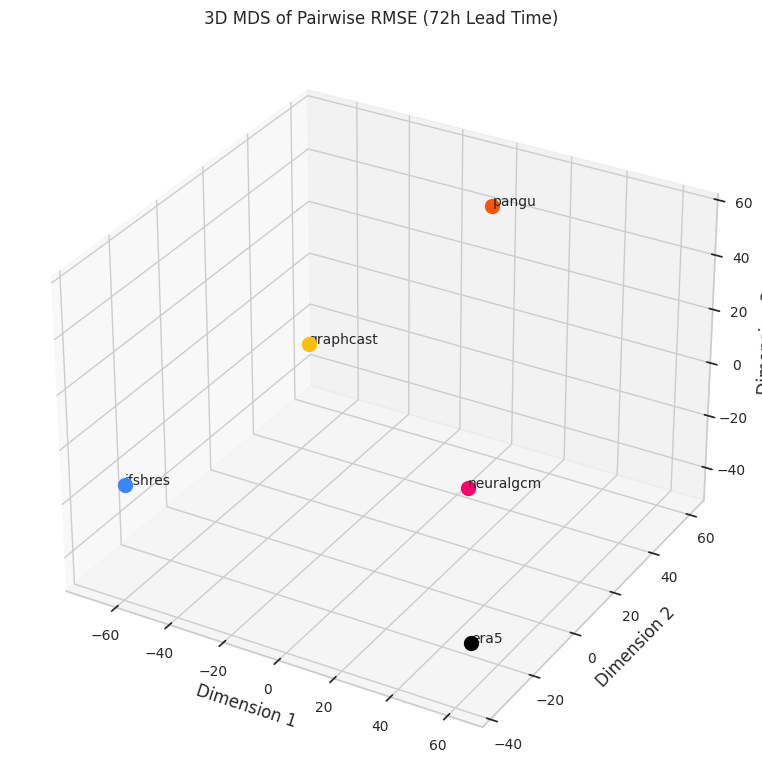

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

labels = pairwise_rmse_result.index
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(labels):
    color = 'black' if 'era5' in label else color_dict.get(label, 'gray')
    ax.scatter(coords_test[i, 0], coords_test[i, 1], coords_test[i, 2],
               color=color, s=100)
    ax.text(coords_test[i, 0], coords_test[i, 1], coords_test[i, 2],
            label, fontsize=10)

ax.set_title('3D MDS of Pairwise RMSE (72h Lead Time)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.tight_layout()
plt.show()


In [32]:
# @title Distance to ERA5

distances = np.linalg.norm(coords_test - coords_test[0], axis=1)
model_names = ['ERA5', 'GraphCast', 'Pangu', 'NeuralGCM', 'IFSHRES']
for name, dist in zip(model_names, distances):
    print(f"{name:12s}: {dist:.2f}")


ERA5        : 0.00
GraphCast   : 104.05
Pangu       : 138.40
NeuralGCM   : 92.80
IFSHRES     : 132.48


In [33]:
import plotly.graph_objs as go

trace = go.Scatter3d(
    x=coords_test[:, 0],
    y=coords_test[:, 1],
    z=coords_test[:, 2],
    mode='markers+text',
    text=labels,
    textposition='top center',
    marker=dict(
        size=6,
        color=[color_dict.get(label, 'gray') if label != 'era5' else 'black' for label in labels]
    )
)

layout = go.Layout(
    title='3D MDS of Pairwise RMSE (72h Lead Time)',
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()


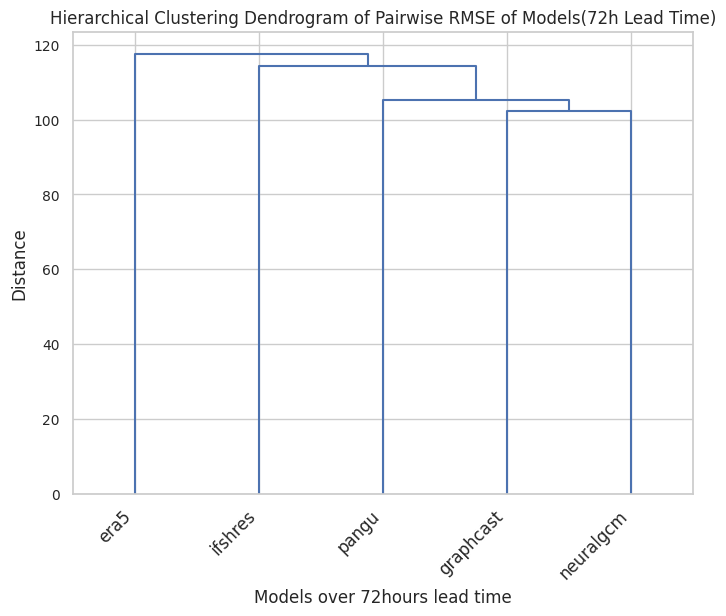

In [35]:
# @title Create the dendrogram plot

# Convert the DataFrame to a NumPy array
distance_matrix = pairwise_rmse_result_test.values

# If your RMSE matrix is symmetric and represents distances,
# convert it to a condensed distance matrix
condensed_distance = squareform(distance_matrix)

# Compute the linkage matrix using a method of your choice (e.g., 'average')
Z = linkage(condensed_distance, method='average')

# Create the dendrogram plot
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.figure(figsize=(8, 6))

# plt.figure(figsize=(12, 8))
dendrogram(Z, labels=pairwise_rmse_result_test.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(72h Lead Time)')
plt.xlabel('Models over 72hours lead time')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45° and align right


# plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(72h Lead Time).pdf', dpi=300, bbox_inches="tight")

plt.show()
